<h1>DATA PREPROCESSING</h1>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
%matplotlib inline

In [2]:
brain_df = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')

In [3]:
brain_df.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [4]:
data = []
for sub_dir_path in glob.glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [5]:
df = pd.DataFrame({"patient_id" : data[::2],
                   "path" : data[1::2]})
df.head()


,patient_id,path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [6]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_25.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_25_mask.tif


In [7]:
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })

brain_df

,patient_id,image_path,mask_path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
...,...,...,...
3924,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3925,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3926,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3927,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


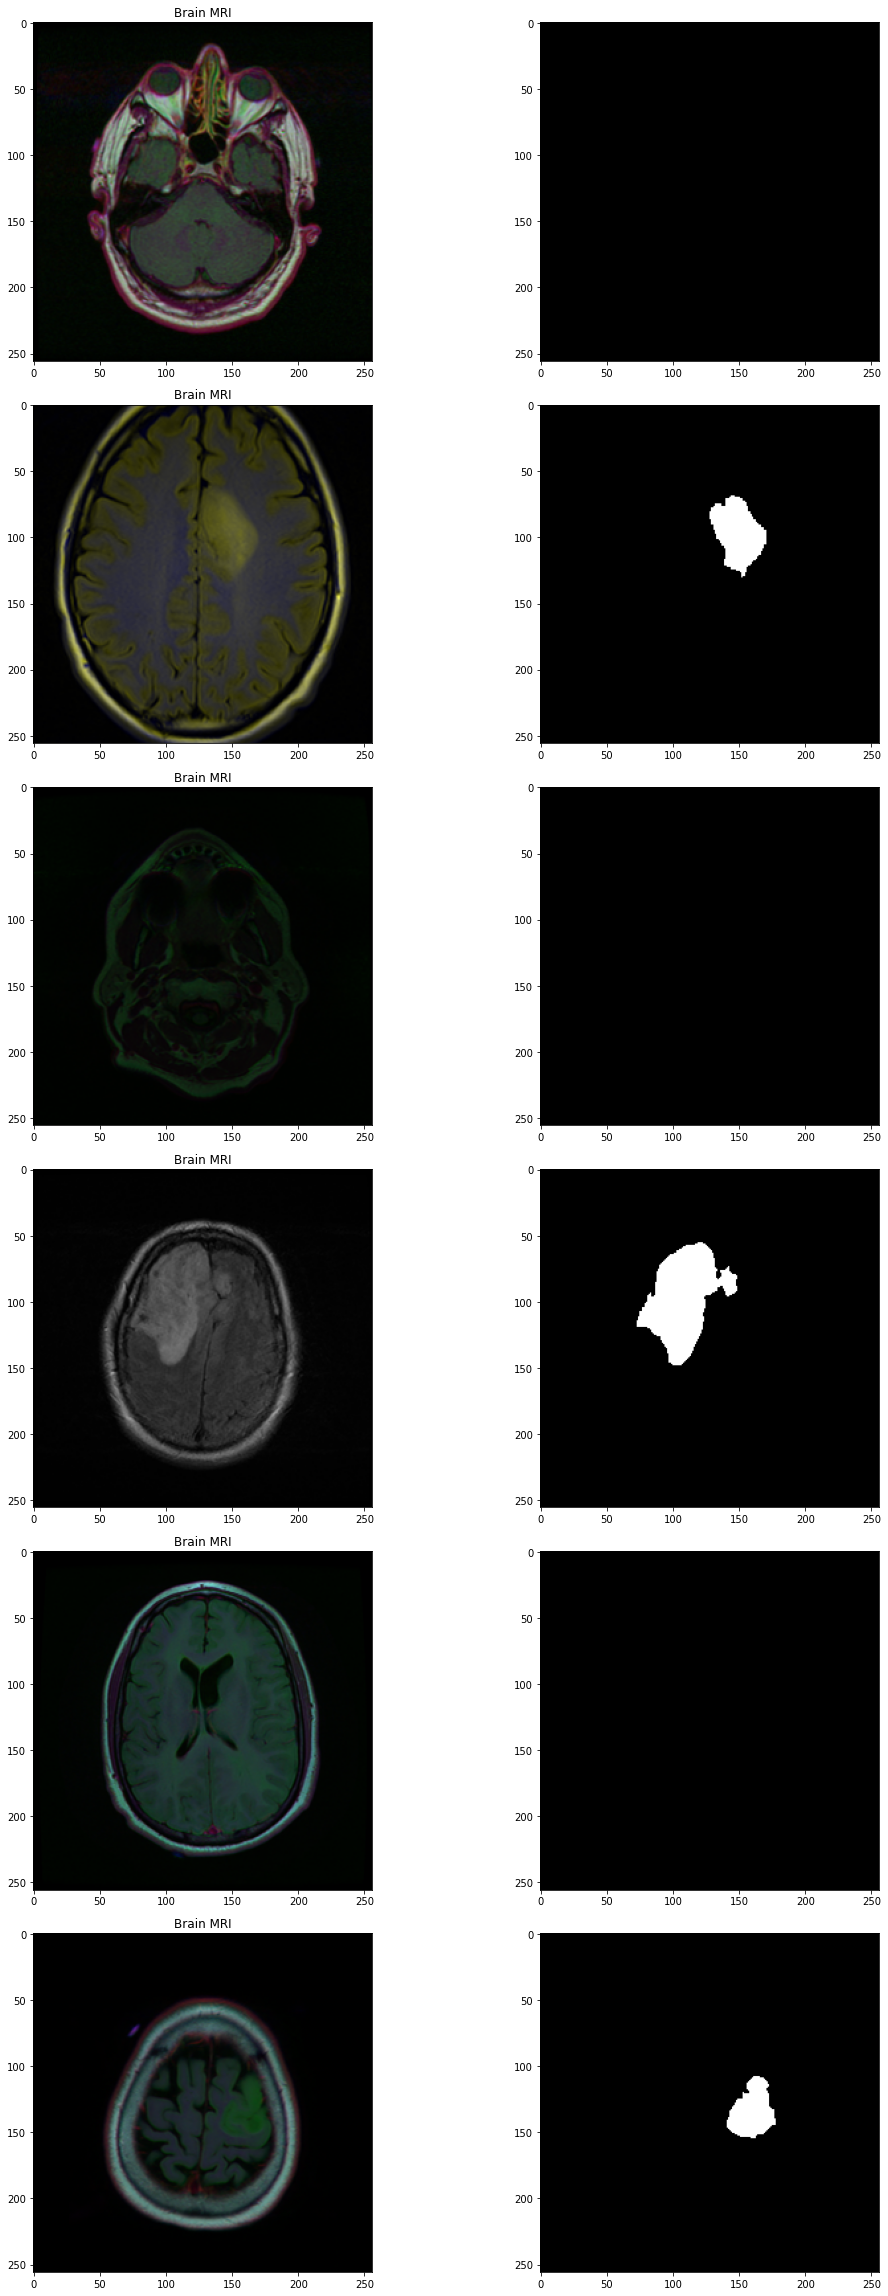

In [8]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately 
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
    i = random.randint(0, len(brain_df)) # select a random index
   # print(np.max(cv2.imread(brain_df.image_path[i])))
   # print(np.min(cv2.imread(brain_df.mask_path[i])))
    axs[count][0].title.set_text("Brain MRI") # set title
    axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 
    #axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
    axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
    
    count += 1

fig.tight_layout()

In [9]:
# Drop the patient id column
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 2)

In [10]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(brain_df_train,test_size = 0.1)
train, test = train_test_split(df_train, test_size = 0.15)

In [11]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [12]:
Batch_size=16

In [13]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(train, Batch_size,
                                train_generator_args,
                                target_size=(256, 256))
test_gener = train_generator(test, Batch_size,
                                dict(),
                                target_size=(256,256))
    

<h1>MODEL</h1>

In [14]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import MaxPooling2D,Activation, BatchNormalization,Conv2D,concatenate, Conv2DTranspose
from tensorflow.keras import datasets,layers
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [15]:
def Unet(pretrained_weights = None,input_size = (256,256,3)):
    inputs = tf.keras.Input(input_size)
    conv1 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(inputs)
    conv1 = Conv2D(64, (3,3), padding = 'same')(conv1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)
    
    conv2 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(128, (3,3), padding = 'same')(conv2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)
    
    conv3 = Conv2D(256, (3,3), activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(256, (3,3), padding = 'same')(conv3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)
    
    conv4 = Conv2D(512, (3,3), activation = 'relu', padding = 'same')(pool3)
    conv4 = Conv2D(512, (3,3),  padding = 'same')(conv4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3,3), activation = 'relu', padding = 'same')(pool4)
    conv5 = Conv2D(1024, (3,3), padding = 'same')(conv5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    
    conv10 = Conv2D(1, (1,1), activation = 'sigmoid')(bn9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    
    #model.summary()
    return model

<h1>Training Model</h1>

In [16]:
smooth=1e-6
def dice_loss(y_true, y_pred):
    y_truef=keras.flatten(y_true)
    y_predf=keras.flatten(y_pred)
    And=keras.sum(y_truef* y_predf)
    return 1-((2* And + smooth) / (keras.sum(y_truef) + keras.sum(y_predf) + smooth))
def dice_coef(y_true,y_pred):
    return 1-dice_loss(y_true,y_pred)
    

In [17]:
model=Unet()
model.summary()
model.compile(optimizer = Adam(lr = 1e-4), loss = dice_loss, metrics = ['accuracy',dice_coef])
STEP_SIZE_TRAIN=len(train)//Batch_size
STEP_SIZE_VALID=len(test)//Batch_size
callbacks = [ModelCheckpoint('Unet_brain_MRI_seg.hdf5', verbose=1,save_weights_only=True)]
#STEP_SIZE_TEST=len(test_generator)//16
model.load_weights('../input/notebookea74c8185b/Unet_brain_MRI_seg.hdf5')
history=model.fit_generator(generator=train_gen,
                   steps_per_epoch=STEP_SIZE_TRAIN,
                   validation_data=test_gener,
                   validation_steps=STEP_SIZE_VALID,
                   epochs=16
)
model.save_weights('Unet_brain_MRI_seg.hdf5')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Found 3005 validated image filenames.
Found 3005 validated image filenames.
Epoch 1/16
187/187 [==============================] - ETA: 0s - loss: 0.1501 - accuracy: 0.9972 - dice_coef: 0.8499Found 531 validated image filenames.
Found 531 validated image filenames.
187/187 [==============================] - 693s 4s/step - loss: 0.1501 - accuracy: 0.9972 - dice_coef: 0.8499 - val_loss: 0.1553 - val_accuracy: 0.9974 - val_dice_coef: 0.8447
Epoch 2/16
187/187 [==============================] - 683s 4s/step - loss: 0.1378 - accuracy: 0.9975 - dice_coef: 0.8628 - val_loss: 0.1362 - val_accuracy: 0.9978 - val_dice_coef: 0.8638
Epoch 3/16
187/187 [==============================] - 668s 4s/step - loss: 0.1289 - accuracy: 0.9978 - dice_coef: 0.8714 - val_loss: 0.1453 - val_accuracy: 0.9977 - val_dice_coef: 0.8547
Epoch 4/16
187/187 [==============================] - 668s 4s/step - loss: 0.1251 - accuracy: 0.9975 - dice_coef: 0.8735 - val_loss: 0.1390 - val_accuracy: 0.9972 - val_dice_coef: 0.861

Text(0.5, 1.0, 'loss graph')

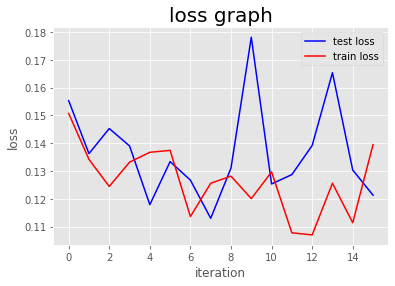

In [18]:
key=history.history
list_trainloss=key['loss']
list_testloss=key['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.legend(["test loss", "train loss"], loc ="upper right")
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 20)

In [19]:
model.load_weights('Unet_brain_MRI_seg.hdf5')

<h1>Evaluating Model</h1>

In [20]:
test_gen = train_generator(df_test, 16,
                               dict(),
                              target_size=(256, 256))
results = model.evaluate(test_gen, steps=len(df_test) / 16)
print(results[0])

Found 393 validated image filenames.
Found 393 validated image filenames.
24/24 [==============================] - 79s 3s/step - loss: 0.1360 - accuracy: 0.9976 - dice_coef: 0.8489
0.135992631316185


0.0005228626
4.7120143e-06


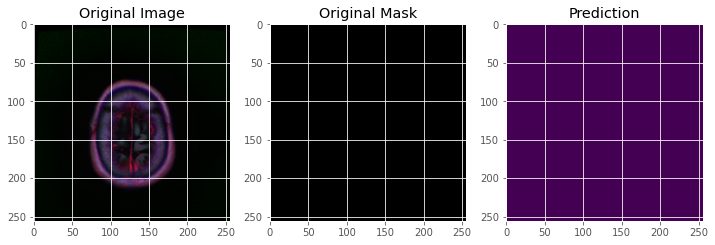

1.0
1.1896806e-19


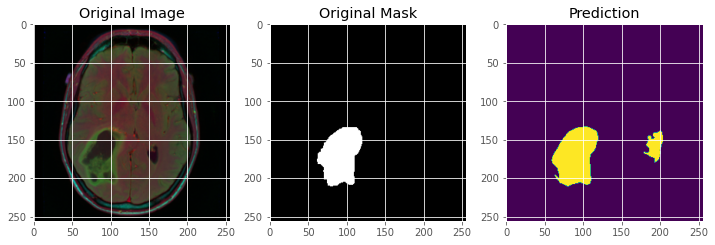

1.0
8.962822e-14


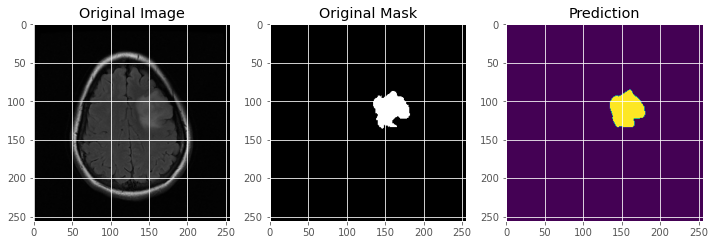

3.831397e-05
3.344817e-09


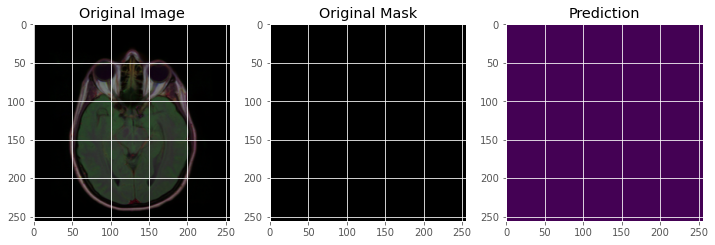

4.263588e-05
7.607223e-08


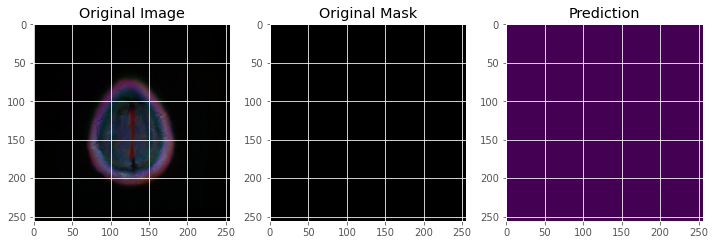

In [21]:
for i in range(5):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['image_path'].iloc[index])
    img = cv2.resize(img ,(256, 256))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask_path'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    print(np.max(pred))
    print(np.min(pred))
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()